In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# Preliminary Analysis of Data.

Text(0.5, 1.0, 'Movies and their corresponding number of ratings')

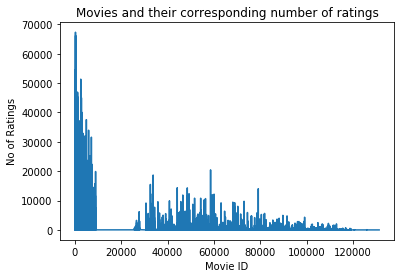

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
ratingsData = pd.read_csv("/content/drive/My Drive/ml-20m/ratings.csv")
ratingsData_1 = ratingsData.groupby('movieId').count().reset_index()
ratingsData_2 = pd.DataFrame()
ratingsData_2['movieId'] = ratingsData_1['movieId']
ratingsData_2['count'] = ratingsData_1['userId']
plt.plot(ratingsData_2['movieId'], ratingsData_2['count'])
plt.xlabel("Movie ID")
plt.ylabel("No of Ratings")
plt.title('Movies and their corresponding number of ratings')

As seen in the plot, the majority chunk of data is contained on the left side of the plot, that is the movies that have been rated more number to times. So to sample our data we have taken the most popular movies (that is the movies that are rated more than a certain number of times).



Text(0.5, 1.0, 'Users and their corresponding number of time they have rated')

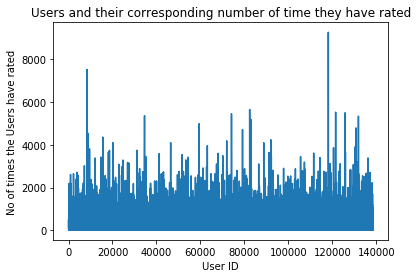

In [0]:
ratingsDataUserCount = ratingsData.groupby('userId').count().reset_index()
ratingsDataUserCount_1 = pd.DataFrame()
ratingsDataUserCount_1['userId'] = ratingsDataUserCount['userId']
ratingsDataUserCount_1['count'] = ratingsDataUserCount['movieId']

plt.plot(ratingsDataUserCount_1['userId'], ratingsDataUserCount_1['count'])
plt.xlabel("User ID")
plt.ylabel("No of times the Users have rated")
plt.title('Users and their corresponding number of time they have rated')

We can see that major number of users have rated few times.
Therefore considering our desired sample size and our business model we have take the most active users i.e users that have rated more than 1500 times. 


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

!java -version
!sudo update-alternatives --config java
!java -version

openjdk version "11.0.4" 2019-07-16
OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3)
OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
* 0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
  2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_222"
OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1ubuntu1~18.04.1-b10)
OpenJDK 64-Bit Server VM (b

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
#importing libraries for spark mllib 
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [0]:
moviesData = spark.read.load("/content/drive/My Drive/ml-20m/movies.csv",format="csv",header=True,inferSchema=True)
ratingsData = spark.read.load("/content/drive/My Drive/ml-20m/ratings.csv",format="csv",header=True,inferSchema=True)
ratingsData.groupBy('movieId')

# Sample 1:  Ratings of the top 500 movies from users that have rated more than 1500 movies


In [0]:
ratingsDataByCount = ratingsData.groupby('movieId').count()
ratingsDataByCount = ratingsDataByCount.sort('count', ascending=False)

#selecting the top 500 most popular movie 
ratingsDataByCount = ratingsDataByCount.limit(500)

#Register the DataFrame as a SQL temporary view
ratingsDataByCount.createOrReplaceTempView("ratingsDataByCount")
ratingsData.createOrReplaceTempView("ratingsData")

ratingsData_1 = spark.sql("SELECT ratingsData.movieId, ratingsData.userId, ratingsData.rating FROM ratingsData, ratingsDataByCount where ratingsData.movieId = ratingsDataByCount.movieId")

#selecting the top 500 most popular movie which have been voted more than 1500 times.
ratingsDataByUserCount = ratingsData.groupby('userId').count()
ratingsDataByUserCount = ratingsDataByUserCount.sort('count', ascending=False)

#Register the DataFrame as a SQL temporary view
ratingsDataByUserCount.createOrReplaceTempView("ratingsDataByUserCount")
ratingsData_1.createOrReplaceTempView("ratingsData_1")

ratingsData_1 = spark.sql("SELECT ratingsData_1.movieId, ratingsData_1.userId, ratingsData_1.rating FROM ratingsDataByUserCount, ratingsData_1 WHERE ratingsData_1.userId = ratingsDataByUserCount.userId and ratingsDataByUserCount.count > 1500")

Sample_1 = ratingsData_1.toPandas()

In [0]:
Sample_1.count()

movieId        220683
userId         220683
rating         220683
pred_rating    220683
dtype: int64

# Sample 2:  Ratings of the top 1000 movies from users that have rated more than 1500 movies

In [0]:
ratingsDataByCount = ratingsData.groupby('movieId').count()
ratingsDataByCount = ratingsDataByCount.sort('count', ascending=False)

#selecting the top 1000 most popular movie 
ratingsDataByCount = ratingsDataByCount.limit(1000)

#Register the DataFrame as a SQL temporary view
ratingsDataByCount.createOrReplaceTempView("ratingsDataByCount")
ratingsData.createOrReplaceTempView("ratingsData")

ratingsData_1 = spark.sql("SELECT ratingsData.movieId, ratingsData.userId, ratingsData.rating FROM ratingsData, ratingsDataByCount where ratingsData.movieId = ratingsDataByCount.movieId")

#selecting the top 1000 most popular movie which have been voted more than 1500 times.
ratingsDataByUserCount = ratingsData.groupby('userId').count()
ratingsDataByUserCount = ratingsDataByUserCount.sort('count', ascending=False)

#Register the DataFrame as a SQL temporary view
ratingsDataByUserCount.createOrReplaceTempView("ratingsDataByUserCount")
ratingsData_1.createOrReplaceTempView("ratingsData_1")

ratingsData_2 = spark.sql("SELECT ratingsData_1.movieId, ratingsData_1.userId, ratingsData_1.rating FROM ratingsDataByUserCount, ratingsData_1 WHERE ratingsData_1.userId = ratingsDataByUserCount.userId and ratingsDataByUserCount.count > 1500")

Sample_2 = ratingsData_2.toPandas()

# Sample 3:  Ratings of the top 1500 movies from users that have rated more than 1500 movies

In [0]:
ratingsDataByCount = ratingsData.groupby('movieId').count()
ratingsDataByCount = ratingsDataByCount.sort('count', ascending=False)

#selecting the top 1500 most popular movie 
ratingsDataByCount = ratingsDataByCount.limit(1500)

#Register the DataFrame as a SQL temporary view
ratingsDataByCount.createOrReplaceTempView("ratingsDataByCount")
ratingsData.createOrReplaceTempView("ratingsData")

ratingsData_1 = spark.sql("SELECT ratingsData.movieId, ratingsData.userId, ratingsData.rating FROM ratingsData, ratingsDataByCount where ratingsData.movieId = ratingsDataByCount.movieId")

#selecting the top 1500 most popular movie which have been voted more than 1500 times.
ratingsDataByUserCount = ratingsData.groupby('userId').count()
ratingsDataByUserCount = ratingsDataByUserCount.sort('count', ascending=False)

#Register the DataFrame as a SQL temporary view
ratingsDataByUserCount.createOrReplaceTempView("ratingsDataByUserCount")
ratingsData_1.createOrReplaceTempView("ratingsData_1")

ratingsData_3 = spark.sql("SELECT ratingsData_1.movieId, ratingsData_1.userId, ratingsData_1.rating FROM ratingsDataByUserCount, ratingsData_1 WHERE ratingsData_1.userId = ratingsDataByUserCount.userId and ratingsDataByUserCount.count > 1500")

Sample_3 = ratingsData_3.toPandas()

In [0]:
Sample_3.count()

movieId    517647
userId     517647
rating     517647
dtype: int64

# Sample 4:  Ratings of the top 2000 movies from users that have rated more than 1500 movies



In [0]:
ratingsDataByCount = ratingsData.groupby('movieId').count()
ratingsDataByCount = ratingsDataByCount.sort('count', ascending=False)

#selecting the top 2000 most popular movie 
ratingsDataByCount = ratingsDataByCount.limit(2000)

#Register the DataFrame as a SQL temporary view
ratingsDataByCount.createOrReplaceTempView("ratingsDataByCount")
ratingsData.createOrReplaceTempView("ratingsData")

ratingsData_1 = spark.sql("SELECT ratingsData.movieId, ratingsData.userId, ratingsData.rating FROM ratingsData, ratingsDataByCount where ratingsData.movieId = ratingsDataByCount.movieId")

#selecting the top 2000 most popular movie which have been voted more than 1500 times.
ratingsDataByUserCount = ratingsData.groupby('userId').count()
ratingsDataByUserCount = ratingsDataByUserCount.sort('count', ascending=False)

#Register the DataFrame as a SQL temporary view
ratingsDataByUserCount.createOrReplaceTempView("ratingsDataByUserCount")
ratingsData_1.createOrReplaceTempView("ratingsData_1")

ratingsData_4 = spark.sql("SELECT ratingsData_1.movieId, ratingsData_1.userId, ratingsData_1.rating FROM ratingsDataByUserCount, ratingsData_1 WHERE ratingsData_1.userId = ratingsDataByUserCount.userId and ratingsDataByUserCount.count > 1500")

Sample_4 = ratingsData_4.toPandas()

In [0]:
Sample_4.count()

movieId    623192
userId     623192
rating     623192
dtype: int64

# Compute the baseline by considering mean rating as the predicted value for the entire sample and calculating the RMSE for each of the samples. 



In [0]:
import math
def Baseline_RMSE(Sample_1):
  temp = Sample_1
  x = temp['rating'].mean()
  for i in range(len(temp)):
    temp['pred_rating'] = x 
  residual_y_test = [a - b for a,b in zip(temp['pred_rating'], temp['rating'])]
  rmse_test = RMSE(residual_y_test)
  return rmse_test

def RMSE(a):
    sum = 0
    for i in range(0, len(a)):
        sum = sum + (a[i]**2)
    rmse = math.sqrt(sum / len(a))
    return rmse

In [0]:
RMSE_Sample1 = Baseline_RMSE(Sample_1)
RMSE_Sample2 = Baseline_RMSE(Sample_2)
RMSE_Sample3 = Baseline_RMSE(Sample_3)
RMSE_Sample4 = Baseline_RMSE(Sample_4)

List_RMSE_Baseline = [RMSE_Sample1, RMSE_Sample2, RMSE_Sample3, RMSE_Sample4]

In [0]:
for i in range(len(List_RMSE_Baseline)):
  print("Baseline RMSE for Sample " + str(i+1) + " is " + str(List_RMSE_Baseline[i]) )

Baseline RMSE for Sample 1 is 1.0176954407887222
Baseline RMSE for Sample 2 is 1.0192983415161732
Baseline RMSE for Sample 3 is 1.0271992072986997
Baseline RMSE for Sample 4 is 1.031131960344556
